# Predict False Positives to Reduce Alert Triage 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
df = pd.read_csv('Security Datasets/GUIDE_Test.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Security Datasets/GUIDE_Test.csv'

In [2]:
# Create a folder named 'data' in your project folder and put the CSVs there
train_data = pd.read_csv('Security Datasets/GUIDE_Train.csv', nrows=10000)
test_data = pd.read_csv('Security Datsets/GUIDE_Test.csv', nrows=10000)

In [3]:
train_data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [4]:
train_data['Category'].unique()

array(['InitialAccess', 'Exfiltration', 'CommandAndControl', 'Execution',
       'SuspiciousActivity', 'Impact', 'Collection', 'CredentialAccess',
       'Persistence', 'Discovery', 'Malware', 'DefenseEvasion', 'Exploit',
       'PrivilegeEscalation', 'LateralMovement', 'Ransomware',
       'UnwantedSoftware'], dtype=object)

In [5]:
train_data['IncidentGrade'].unique()

array(['TruePositive', 'FalsePositive', 'BenignPositive', nan],
      dtype=object)

In [6]:
train_data['IncidentGrade'].value_counts()

BenignPositive    4391
TruePositive      3446
FalsePositive     2110
Name: IncidentGrade, dtype: int64

In [7]:
# Percentage count summary of Incident Grade classes
Grade_Ratio=train_data['IncidentGrade'].value_counts() * 100 / train_data['IncidentGrade'].shape[0]
print (Grade_Ratio)

BenignPositive    43.91
TruePositive      34.46
FalsePositive     21.10
Name: IncidentGrade, dtype: float64


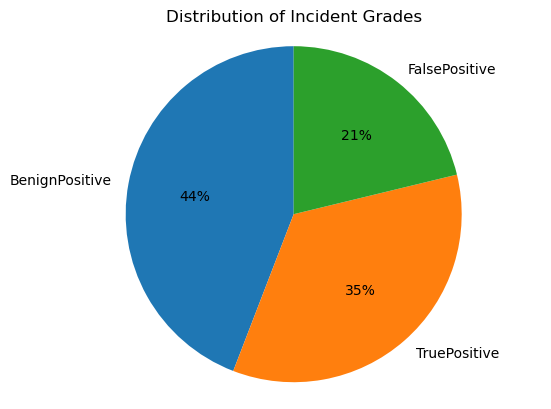

In [8]:
plt.pie(Grade_Ratio, labels = Grade_Ratio.index, autopct='%1.0f%%', startangle=90) # use index for label bec grade ratio is a series
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Incident Grades')
plt.show()

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  int64  
 1   OrgId               10000 non-null  int64  
 2   IncidentId          10000 non-null  int64  
 3   AlertId             10000 non-null  int64  
 4   Timestamp           10000 non-null  object 
 5   DetectorId          10000 non-null  int64  
 6   AlertTitle          10000 non-null  int64  
 7   Category            10000 non-null  object 
 8   MitreTechniques     4201 non-null   object 
 9   IncidentGrade       9947 non-null   object 
 10  ActionGrouped       59 non-null     object 
 11  ActionGranular      59 non-null     object 
 12  EntityType          10000 non-null  object 
 13  EvidenceRole        10000 non-null  object 
 14  DeviceId            10000 non-null  int64  
 15  Sha256              10000 non-null  int64  
 16  IpAdd

In [10]:
train_data.isnull().sum()

Id                       0
OrgId                    0
IncidentId               0
AlertId                  0
Timestamp                0
DetectorId               0
AlertTitle               0
Category                 0
MitreTechniques       5799
IncidentGrade           53
ActionGrouped         9941
ActionGranular        9941
EntityType               0
EvidenceRole             0
DeviceId                 0
Sha256                   0
IpAddress                0
Url                      0
AccountSid               0
AccountUpn               0
AccountObjectId          0
AccountName              0
DeviceName               0
NetworkMessageId         0
EmailClusterId        9881
RegistryKey              0
RegistryValueName        0
RegistryValueData        0
ApplicationId            0
ApplicationName          0
OAuthApplicationId       0
ThreatFamily          9923
FileName                 0
FolderPath               0
ResourceIdName           0
ResourceType          9992
Roles                 9789
O

## Feature Selection

### TimeStamp

In [11]:
# Parse Timestamp to datetime
# Handles strings like: 2024-06-04T22:56:27.000Z
train_data["Timestamp"] = pd.to_datetime(train_data["Timestamp"], errors="coerce")

# Derive simple, leakage-safe time features
train_data["hour"] = train_data["Timestamp"].dt.hour.fillna(-1).astype(int)
train_data["dow"] = train_data["Timestamp"].dt.dayofweek.fillna(-1).astype(int)  # 0=Mon
train_data["is_weekend"] = train_data["dow"].isin([5,6]).astype(int)

In [12]:
train_data['Timestamp'].unique()

<DatetimeArray>
['2024-06-04 06:05:15+00:00', '2024-06-14 03:01:25+00:00',
 '2024-06-13 04:52:55+00:00', '2024-06-10 16:39:36+00:00',
 '2024-06-15 01:08:07+00:00', '2024-06-10 13:30:56+00:00',
 '2024-06-14 23:19:45+00:00', '2024-06-06 13:39:23+00:00',
 '2024-06-09 10:21:29+00:00', '2024-06-08 02:08:01+00:00',
 ...
 '2024-06-05 02:18:21+00:00', '2024-06-10 08:33:51+00:00',
 '2024-06-04 08:51:01+00:00', '2024-06-11 09:21:57+00:00',
 '2024-05-30 22:29:04+00:00', '2024-06-11 16:43:21+00:00',
 '2024-06-07 06:51:11+00:00', '2024-06-07 23:48:32+00:00',
 '2024-06-05 18:43:59+00:00', '2024-06-15 12:11:19+00:00']
Length: 9580, dtype: datetime64[ns, UTC]

In [14]:
# List to store columns with more than 40% null values, these shoul be dropped as they are too significantly empty
columns_with_high_null = []

total_rows = len(train_data) 

for column in train_data.columns:
    
    if train_data[column].isnull().sum() / total_rows > 0.4:
        columns_with_high_null.append(column)

print("Columns with more than 40% null values:", columns_with_high_null)

Columns with more than 40% null values: ['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']


In [21]:
 clean_train_data= train_data.drop('MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles')

/var/folders/zp/nhxn5fq50zq9w6q_pzz259600000gn/T/ipykernel_9828/4017279622.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  clean_train_data= train_data.drop('MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles')


ValueError: For argument "inplace" expected type bool, received type str.

In [ ]:
'AntispamDirection', 'SuspicionLevel', 'LastVerdict',

<AxesSubplot: >

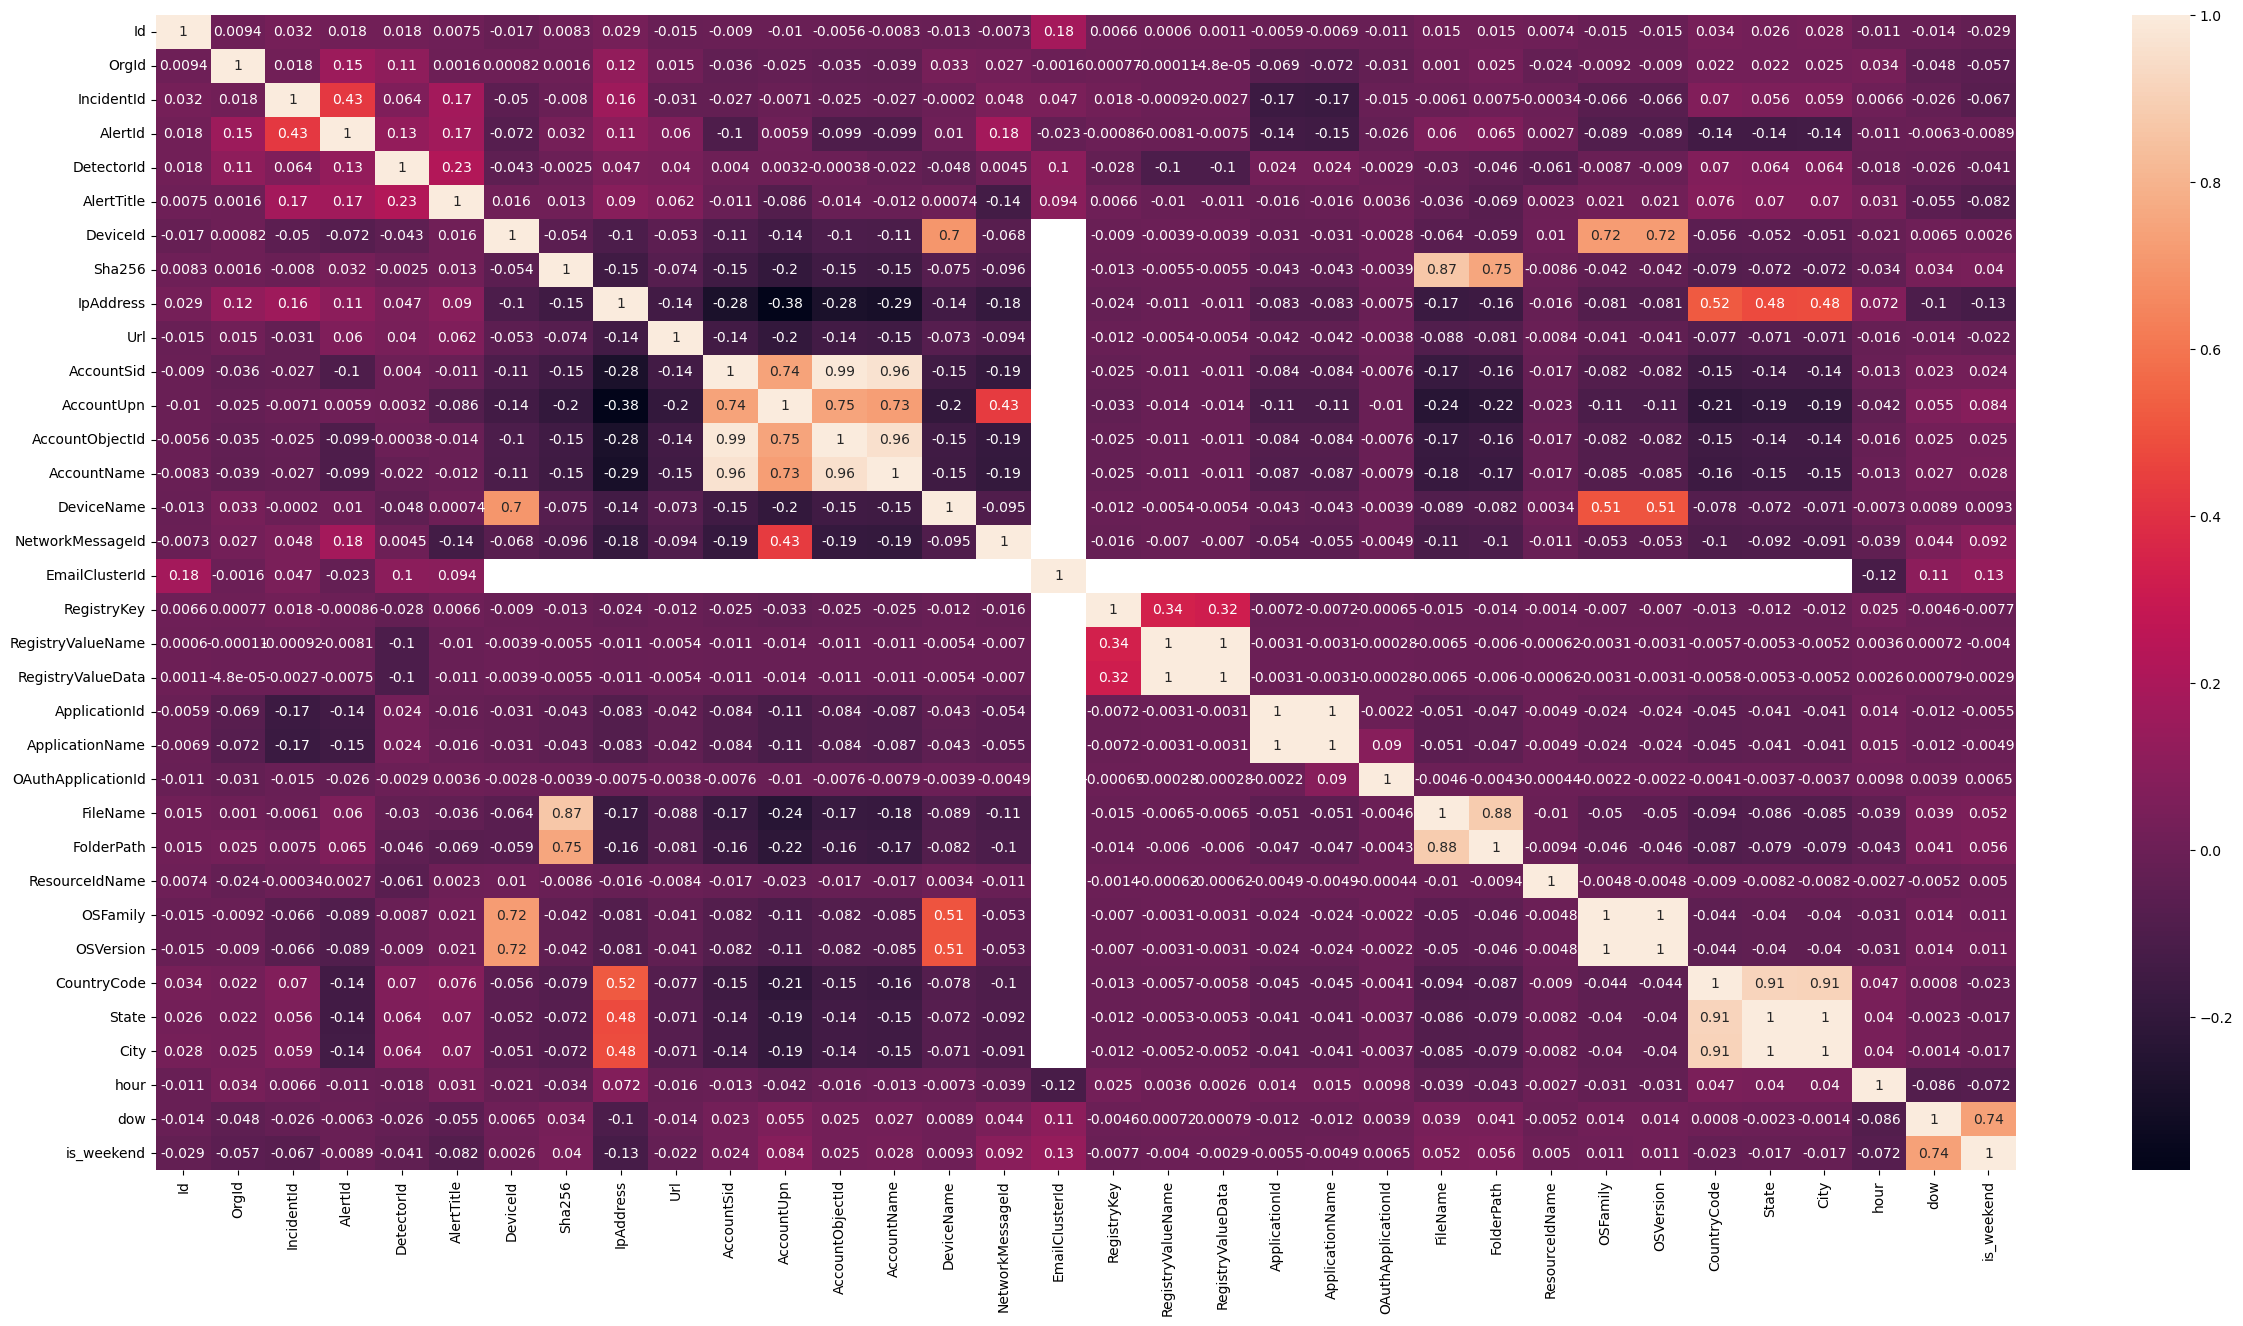

In [22]:
plt.figure(figsize=(30, 15))
sns.heatmap(train_data.corr(), annot=True)